# COGS 108 - Final Project 

# Overview

This project looks into the relationship between density, user reviews and health violations of restaurants in North Carolina. By exploring the data of different restaurants and its position and review, we were able to conclude that there is not a strong relationship between the variables under examination.

# Name & PID

- Name: Kaihang Guo
- PID: A15567387

# Research Question

IS there a relationship between density, user reviews and health violations of a restaurant? Can consumer input and location improve the priority of health evaluations for restaurants?

## Background and Prior Work

Due to the uneven ratio of health inspectors to restaurants, there has been many prior studies that look into how the process can be made more efficient so that health inspectors are not assigned to restaurants randomly. There was a study that looked into the relationship between density of health violations and zipcodes. Zipcodes that were more densely populated with restaurants contained a majority of the health violations within the city. The conclusion was that health inspectors should prioritize zipcodes that are more densely populated. (1)

When it comes to the health standards of a restaurant, the group that it affects the most are the consumers. There have been studies that gathered data from consumers to gauge their thoughts on health inspections and the level of influence the results should have. The study concluded that consumers' expectations of health scores were much higher than what they were on average in reality and that there should be more inspections throughout the year. (2)

References (include links):

1) https://nycdatascience.com/blog/student-works/san-francisco-restaurant-inspection-analysis-visualization/

2) https://www.elsevier.com/about/press-releases/research-and-journals/restaurant-inspections-public-perceptions-vs.-reality

# Hypothesis


When consumers go to restaurants, they tend to take into account more than just the quality of the food in their review of the experience; this is more accurate for areas with a higher density of restaurants as it suggests the area is densely populated. Therefore, there should be a relationship between user reviews and health violations and by using the consumers' input, the priority of health evaluations can be fine tuned to prioritize which restaurants should be inspected.

# Dataset(s)

This dataset contains information about 3000 restaurants in North Carolina, such as its location and contact information.

- Dataset Name: restaurants
- Link to the dataset: restaurants.csv
- Number of observations: 3324

This dataset contains information of restuarant violations in North Carolina, including the violation and its severity.

- Dataset Name: violations
- Link to the dataset: violations.csv
- Number of observations: 189802

This dataset contains information of restaurants from Yelp, such as its average review rating and number of reviews. 

- Dataset Name: yelp
- Link to the dataset: yelp.csv
- Number of observations: 3688

In order to combine these datasets, we will have to merge restaurants and violations by hsisid and then merge with yelp by address. 

# Setup

Before we start, we will import all the packages we need for our analysis.

In [1]:
# Imports 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

We first load in the datasets that we will be working with.

In [2]:
restaurants = pd.read_csv('restaurants.csv')
violations = pd.read_csv('violations.csv')
yelp = pd.read_csv('yelp.csv')

# Data Cleaning

Next, we should remove all the columns in the data frames that we do not need for our analysis. We are only interested in the review of a restaurant and whether there has been a violation so we will drop everything else that is irrelevant.

In [3]:
restaurants = restaurants.drop(columns = ["X.objectid", "name", "address2", "city", "state", "restaurantopendate", "x", "y", "geocodestatus", "phonenumber", "facilitytype"])
violations = violations.drop(columns = ["comments", "shortdesc", "severity", "critical", "X.objectid", "inspectdate", "statecode", "category", "pointvalue", "questionno", "violationtype", "count", "cdcriskfactor", "cdcdataitem", "observationtype", "inspectedby"])
violations.drop_duplicates(subset ="hsisid", keep = 'first', inplace = True) 
yelp = yelp.drop(columns = ["review_count", "id", "is_closed", "latitude", "longitude", "italian", "newamerican", "chicken_wings", "delis", "bars", "salad", "seafood", "bbq", "sandwiches", "pizza", "tradamerican", "burgers", "mexican", "grocery", "breakfast_brunch", "coffee", "chinese", "bakeries", "sushi", "hotdogs", "phone", "price"])

#### Functions required to combine the data into one data frame.

Since some of the zipcodes in restaurants contain a zipcode in the form xxxxx-xxxx, we need to create a function to standardize the zip so that we can merge the dataframes. remove_zip will remove the -xxxx portion if it exists in the zipcode.

In [4]:
def remove_zip(string):
    
    if string == np.nan:
        return np.nan
    elif len(str(string)) > 5:
        output = string[:5]
    else:
        output = string

    return output

With the function defined, we can now merge yelp with restaurants and violations. By using the function, we can merge both the postalcode and zip_code columns into one column to preserve as much of our data as possible.

In [5]:
rv = pd.merge(restaurants, violations, on='hsisid', how='left')
rv['postalcode'] = rv['postalcode'].apply(remove_zip)
df = pd.merge(yelp, rv, on='address1', how='left')

zipcode = df["zip_code"].astype(str) + df["postalcode"].astype(str)
zipcode.columns = ['zipcode']
df['zipcode'] = zipcode
df['zipcode'] = df['zipcode'].apply(remove_zip)

Since not all restaurants have had a violation, we will have to look at df where the violationcode is null and replace that with zeroes to symbolize not having a violation. To simplify the dataframe, we will create a new column to represent whether the restaurant had a health violation, based on the violations dataframe.

In [6]:
df['violationcode'] = df['violationcode'].fillna(False)
df.loc[df.violationcode != False, 'violationcode'] = True

Since the columns hsisd and address1 were only used to merge the datasets together, we can now drop them as we do not need it in our analysis. The information from the two columns zip_code and postalcode was used to create zipcode, so we will not need that information anymore either.

In [7]:
df = df.drop(columns = ['hsisid', 'address1', 'postalcode', 'zip_code'])
df = df.set_index('name')
df

,rating,violationcode,zipcode
name,,,
42nd street oyster bar - rdu airport,2.5,False,27560
aldi foods,4.0,False,27519
luciano pizzeria ristorante,5.0,False,27612
olive garden italian restaurant,3.0,False,27893
subway,3.5,False,27896
...,...,...,...
carter-finley stadium,3.5,False,27607
raleigh little theatre,3.5,False,27607
"sky zone trampoline park, durham",4.0,False,27701


# Data Analysis & Results

First we will look at the distribution of violationcodes and reviews separately.

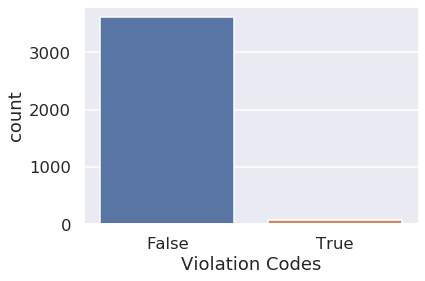

In [8]:
sns.countplot(x='violationcode', data=df)
plt.xlabel('Violation Codes');

According to this chart, we can see that a majority of the restaurants in our dataset do not have any violation codes.

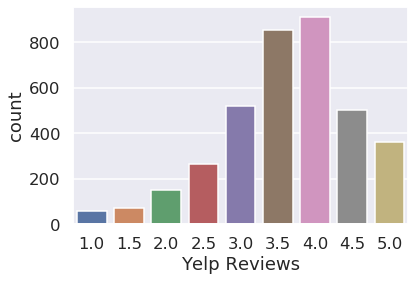

In [9]:
sns.countplot(x='rating', data=df)
plt.xlabel('Yelp Reviews');

The Yelp Reviews graph also show that a majority of yelp reviews are around a 3 to 4 out of 5, which supports our hypothesis that higher reviews can mean less health violations.

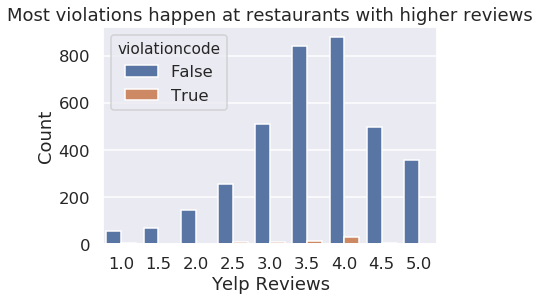

In [10]:
ax = sns.countplot(x='rating', hue='violationcode', data=df)
ax.set_title('Most violations happen at restaurants with higher reviews', loc='center')
ax.set_ylabel('Count')
ax.set_xlabel('Yelp Reviews');

However, by putting the data together, we can see that most of the restaurants with health violations also have higher Yelp reviews which contradicts the idea that user reviews can help dictate the priority of health inspections at restaurants. Let's confirm this idea using regression.

In [11]:
outcome, predictors = patsy.dmatrices('rating ~ violationcode', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.032
Date:                Wed, 10 Jun 2020   Prob (F-statistic):             0.0249
Time:                        22:27:08   Log-Likelihood:                -4768.9
No. Observations:                3693   AIC:                             9542.
Df Residuals:                    3691   BIC:                             9554.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.62

As we can see, the coefficient for violation code is very close to zero which suggests that there is not a strong relationship between Yelp reviews and health violations as we could see in the bar plot earlier.

We will now look at whether there is a relationship between zipcodes and health violations. Based on the graph below, the number of restaurants in each zipcodes are relatively spread out.

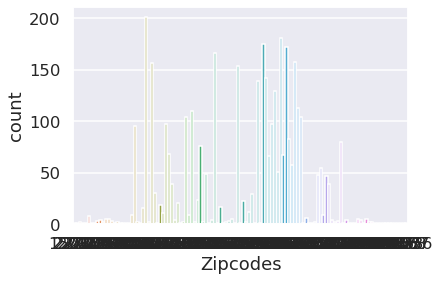

In [12]:
sns.countplot(x='zipcode', data=df)
plt.xlabel('Zipcodes');

We then look at the relationship between zipcode and health violations directly.

In [13]:
v_encoded = pd.get_dummies(df, columns=df.columns)
v_model = v_encoded.reindex(columns = df.columns, fill_value=0)
outcome2, predictors2 = patsy.dmatrices('violationcode ~ zipcode', v_model)
mod2 = sm.OLS(outcome2, predictors2)
res2 = mod2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:          violationcode   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                nan
Time:                        22:27:12   Log-Likelihood:                    inf
No. Observations:                3693   AIC:                              -inf
Df Residuals:                    3692   BIC:                              -inf
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept           0          0        nan        n

As we can see in this table, the coefficient for zipcode is 0 which means that there is not a strong relationship between health violation and zipcode. Since the standard error is 0, the pvalue is nan. This suggests that the result from the table is valid.

# Ethics & Privacy

Since the data is centralized in North Carolina, it may not be accurate in the sense of all restaurants in the United States. We can check for this by looking at the data from other samples of the population and also seeing if there are any situations that affect North Carolina specifically. If that was the case, then we would have to generalize how we got the samples for the data. Instead of only getting data from North Carolina, obtain random data from throughout the United States.

If my hypothesis turned out to be correct, it could benefit the health department and the general public as they would be able to search for health violations more efficiently. Then the standard for health at restaurants would go up, which benefits the patrons that visit those restaurants. It could harm businesses as if the data makes a wrong guess on whether a restaurant is at risk of health violations, then it could waste restaurant resources. Also, since the information is based on data from users, theoretically, they are able to affect the results of a restaurant's likeliness to require a health inspection if the users had the motivation to. Restaurant reviews also discuss other aspects of the consumer experience such as parking and wait times. These may also be describe with the same negative or postive adjectives for a restaurant's cleanliness. These issues can generally be avoided by tweaking the process of data collection so by using machine learning, the algorithm can be improved and trained through old datasets.


# Conclusion & Discussion

I attempted to look at whether there was a relationship between user reviews zipcodes and health violations. I hypothesized that there would be a relationship between the three as many customers write detailed reviews about a restaurant, including the cleanliness of a restaurant. I also expected that there would be a relationship between health violations and zipcodes as a zipcode with a higher density of restaurants could mean that there are more restaurants that violate health regulations. However, the result that I arrived at did not support my hypothesis.

By looking through the data of a few thousand restaurants and comparing the results to whether there was a health violation, I arrived at the result that there is not a strong relationship between user reviews, zipcodes and health violations. However, this does not mean that there is not a relationship, because the data that was used is limited. Since the data is from one state, there may be other factors that caused the results that I received. Also, the reviews that were used generalized. Ideally, if the data contained individual reviews, it would be possible to use machine learning to look through reviews for a restaurant to determine whether it may be violating health standards or not. If this can be proved to be effective, then it would be able to increase the productivity of health inspections which in turn will motivate customers to go to restaurants, boosting the economy.